<a href="https://colab.research.google.com/github/wh1t3tea/cv/blob/main/FashnMNISTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

In [50]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
len(trainloader), len(testloader)

(1875, 313)

In [4]:
class_names = {0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

In [ ]:
def show_random_image(dataset, num_imgs):
  for index in range(1, num_imgs+1):
    random_index = np.random.randint(0, len(dataset))
    plt.figure(figsize=[8, 12], dpi=50)
    plt.imshow(dataset[random_index][0].reshape(28, 28, 1))
    plt.title(class_names[dataset[random_index][1]])
    plt.show();

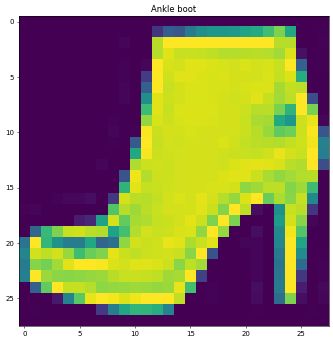

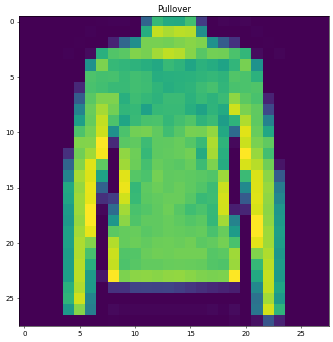

In [ ]:
show_random_image(trainset, 2)

Напишем простую FC архитектуру

In [ ]:
class FullyConnectedNet(nn.Module):
  def __init__(self, in_features, out_features):
    super(FullyConnectedNet, self).__init__()

    self.flat = nn.Flatten()
    self.inp_layer = nn.Linear(in_features, 64)
    self.fc_layer1 = nn.Linear(64, 64)
    self.fc_layer2 = nn.Linear(64, 128)
    self.fc_layer3 = nn.Linear(128, 128)
    self.outp = nn.Linear(128, out_features)

  def forward(self, x):
    inp = self.flat(x)
    fc0 = F.relu(self.inp_layer(inp))
    fc1 = F.relu(self.fc_layer1(fc0))
    fc2 = F.relu(self.fc_layer2(fc1))
    fc3 = F.relu(self.fc_layer3(fc2))
    output = self.outp(fc3)

    return output


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

fc_model = FullyConnectedNet(28*28, 10).to(device)
summary(fc_model, input_size=(1, 28, 28), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [32, 784]               0
            Linear-2                   [32, 64]          50,240
            Linear-3                   [32, 64]           4,160
            Linear-4                  [32, 128]           8,320
            Linear-5                  [32, 128]          16,512
            Linear-6                   [32, 10]           1,290
Total params: 80,522
Trainable params: 80,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.29
Params size (MB): 0.31
Estimated Total Size (MB): 0.69
----------------------------------------------------------------


In [ ]:
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_model.parameters())

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [13]:
def train_loop(model, max_epochs, criterion, optimizer, tr_loader, val_loader):

  train_loss_list = []
  validation_loss_list = []
  train_accuracy_list = []
  valid_accuracy_list = []

  for epoch in range(max_epochs):

    train_losses = []
    validation_losses = []
    best_model = model
    train_accuracy = []
    valid_accuracy = []

    model.train()

    for x_batch, y_batch in tr_loader:
      optimizer.zero_grad()
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      train_preds = model(x_batch)
      tr_loss = criterion(train_preds, y_batch)
      tr_loss.backward()
      optimizer.step()
      train_losses.append(tr_loss)
      tr_batch_accuracy = accuracy_score(y_batch.to('cpu').detach().numpy(), F.softmax(train_preds, dim=0).argmax(-1).to('cpu').detach().numpy())
      train_accuracy.append(tr_batch_accuracy)

    if epoch > 0:

      with torch.inference_mode():
        if sum(train_accuracy) / len(tr_loader) > max(train_accuracy):
          best_model = model()

    train_loss_list.append(sum(train_losses)/ len(tr_loader))
    train_accuracy_list.append(sum(train_accuracy)/ len(tr_loader))


    model.eval()

    for x_batch, y_batch in val_loader:

      with torch.inference_mode():
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        val_preds = model(x_batch)
        val_loss = criterion(val_preds, y_batch)
        val_batch_accuracy = accuracy_score(y_batch.to('cpu').detach().numpy(), F.softmax(val_preds, dim=0).argmax(-1).to('cpu').detach().numpy())
        validation_losses.append(val_loss)
        valid_accuracy.append(val_batch_accuracy)

    valid_accuracy_list.append(sum(valid_accuracy)/ len(val_loader))
    validation_loss_list.append(sum(validation_losses)/ len(val_loader))

    print(f"Epoch - {epoch+1}, train_loss: {train_loss_list[epoch]}, val_loss: {validation_loss_list[epoch]}")

  return best_model, train_loss_list, validation_loss_list, train_accuracy_list, valid_accuracy_list




In [ ]:
fc_model, *history = train_loop(fc_model, epochs, criterion, optimizer, trainloader, testloader)

Epoch - 1, train_loss: 0.3344050943851471, val_loss: 0.35996368527412415
Epoch - 2, train_loss: 0.3158520460128784, val_loss: 0.3669193387031555
Epoch - 3, train_loss: 0.30146390199661255, val_loss: 0.35770246386528015
Epoch - 4, train_loss: 0.2890569269657135, val_loss: 0.3461552560329437
Epoch - 5, train_loss: 0.2790663242340088, val_loss: 0.364066481590271
Epoch - 6, train_loss: 0.27287188172340393, val_loss: 0.3487548828125
Epoch - 7, train_loss: 0.2615484297275543, val_loss: 0.34649142622947693
Epoch - 8, train_loss: 0.2567681074142456, val_loss: 0.3593563735485077
Epoch - 9, train_loss: 0.24705082178115845, val_loss: 0.3605996370315552
Epoch - 10, train_loss: 0.24186265468597412, val_loss: 0.38198184967041016
Epoch - 11, train_loss: 0.23605956137180328, val_loss: 0.34144896268844604
Epoch - 12, train_loss: 0.2306448519229889, val_loss: 0.3554086983203888
Epoch - 13, train_loss: 0.22559858858585358, val_loss: 0.3715131878852844
Epoch - 14, train_loss: 0.2196129411458969, val_loss:

In [ ]:
len(history)

4

In [ ]:
tr_loss, val_loss, tr_acc, val_acc = history
tr_loss = [x.to('cpu').detach().numpy().item() for x  in tr_loss]
val_loss = [x.to('cpu').detach().numpy().item() for x  in val_loss]

In [ ]:
import seaborn as sns

In [22]:
def results_plot(tr_res, val_res, title):
  plt.figure(figsize=(12, 8), dpi=80)
  sns.lineplot(tr_res, palette='red')
  plt.legend('Train')
  sns.lineplot(val_res, palette='blue')
  plt.legend('Validation')
  plt.title(title)
  plt.show();

<ipython-input-127-ca80fd25c1be>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-127-ca80fd25c1be>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


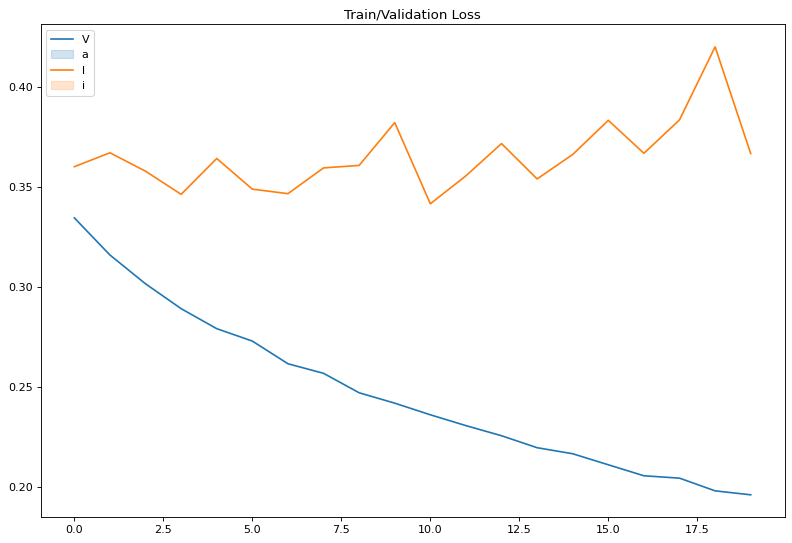

In [ ]:
results_plot(tr_loss, val_loss, 'Train/Validation Loss')

Как видно по графикам модель быстро стала переобучаться, так как лосс на тренировочной выборке плавно падал, а на тестовой с большим количеством локальных экстремумов рос

<ipython-input-127-ca80fd25c1be>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-127-ca80fd25c1be>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


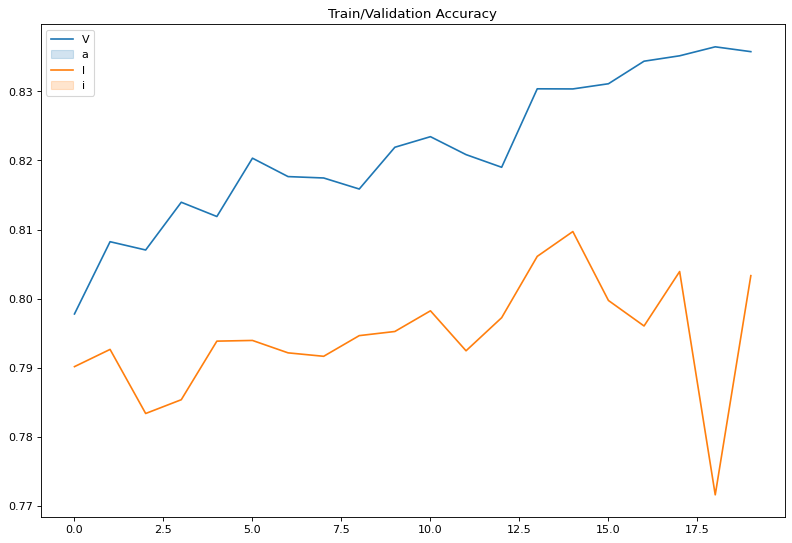

In [ ]:
results_plot(tr_acc, val_acc, 'Train/Validation Accuracy')

Точность модели росла на тестовой выборке, но ближе к 15 эпохе тоже стала стремительно падать. Виной этому может быть маленький размер самой модели, полносвязной модели с 80к параметров тяжело добиться стабильных и высоких результатов в задачах компьютерного зрения

Добавление сверточных слоев в модель

За основу возьмем энкодер модели vgg16

Для использования архитектуры vgg16 нам необходимо изменить трансформацию данных при загрузке. Напишем новый transformer и Dataload'еры

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
batch_size = 32
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [ ]:
model_conv = VGG16().to(device)
summary(model_conv, (1, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 128, 112, 112]         147,584
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 56, 56]         590,080
        MaxPool2d-10          [-1, 256, 28, 28]               0
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
        MaxPool2d-14          [-1, 512,

vgg16 содержит уже намного больше весов, чем наша полносвязная модель

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=0.0003)
epochs = 20

In [ ]:
model_conv, *history = train_loop(model_conv, epochs, criterion, optimizer, trainloader, testloader)

Epoch - 1, train_loss: 2.3026442527770996, val_loss: 2.3026325702667236
Epoch - 2, train_loss: 2.302624225616455, val_loss: 2.3026793003082275


KeyboardInterrupt: ignored

К сожалению, ресурсы colab без подписки не способствуют обучению моделей с 130 млн параметрами на борту, поэтому вместо vgg16 я попробую использовать более легковесную архитектуру

In [5]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )

In [21]:
model = ResNet_18(1, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
resnet_model, *history = train_loop(model, 10, loss_fn, optimizer, trainloader, testloader)

Epoch - 1, train_loss: 0.4618638753890991, val_loss: 0.3407064378261566
Epoch - 2, train_loss: 0.3248165547847748, val_loss: 0.30178534984588623
Epoch - 3, train_loss: 0.28333234786987305, val_loss: 0.2888128161430359
Epoch - 4, train_loss: 0.2551875710487366, val_loss: 0.268167108297348
Epoch - 5, train_loss: 0.23159167170524597, val_loss: 0.2658866047859192
Epoch - 6, train_loss: 0.2139907032251358, val_loss: 0.2702632248401642
Epoch - 7, train_loss: 0.18959161639213562, val_loss: 0.2425488829612732
Epoch - 8, train_loss: 0.17070168256759644, val_loss: 0.25455451011657715
Epoch - 9, train_loss: 0.15658995509147644, val_loss: 0.2525947690010071
Epoch - 10, train_loss: 0.1412932276725769, val_loss: 0.24470604956150055


In [27]:
tr_loss, ts_loss, tr_acc, ts_acc = history
tr_loss = [x.to('cpu').detach().numpy().item() for x  in tr_loss]
ts_loss = [x.to('cpu').detach().numpy().item() for x  in ts_loss]

<ipython-input-22-07b15f836379>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-22-07b15f836379>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


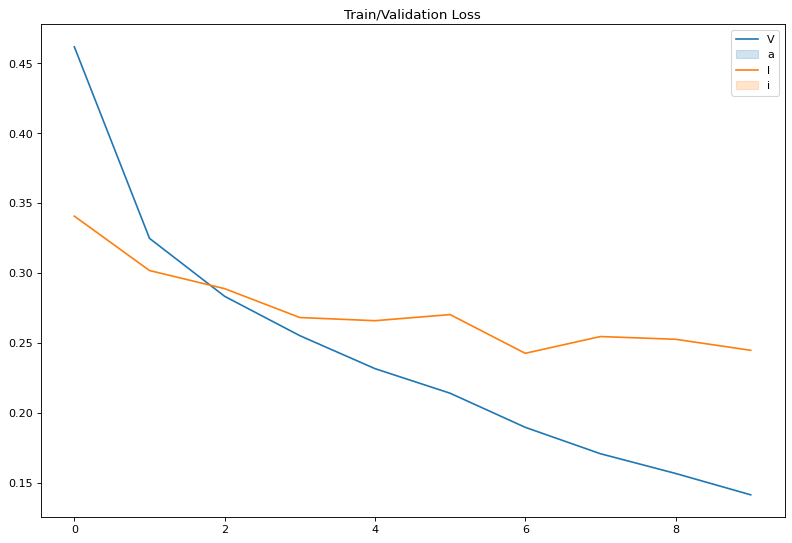

In [28]:
import seaborn as sns
results_plot(tr_loss, ts_loss, 'Train/Validation Loss')

<ipython-input-22-07b15f836379>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-22-07b15f836379>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


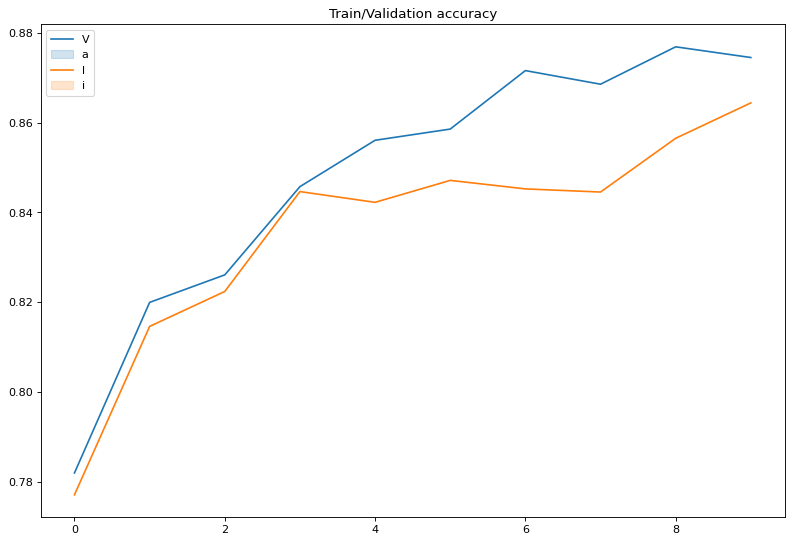

In [29]:
results_plot(tr_acc, ts_acc, 'Train/Validation accuracy')

In [30]:
max(ts_acc)

0.8644169329073482

Использование сверточных слоев заметно увеличило качество на тестовой выборке. Модель достигла более высокой accuracy и за меньшее количество эпох

# Обучение с аугментацией тренировочной выборки

In [39]:
from torchvision.transforms import v2

train_transformer = transforms.v2.Compose(
    [v2.ToTensor(),
    v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize([0.5], [0.5])]
)

test_transformer = transforms.v2.Compose(
    [v2.ToTensor(),
    v2.Normalize([0.5], [0.5])]
)

batch_size = 32
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=train_transformer)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=test_transformer)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [40]:
model = ResNet_18(1, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
resnet_model_aug, *history = train_loop(model, 10, loss_fn, optimizer, trainloader, testloader)

Epoch - 1, train_loss: 1.0667237043380737, val_loss: 0.6044602394104004
Epoch - 2, train_loss: 0.8428162932395935, val_loss: 0.8206324577331543
Epoch - 3, train_loss: 0.7728156447410583, val_loss: 0.4185512065887451
Epoch - 4, train_loss: 0.7201548218727112, val_loss: 0.4015626013278961
Epoch - 5, train_loss: 0.6789122223854065, val_loss: 0.3491213917732239
Epoch - 6, train_loss: 0.6595409512519836, val_loss: 0.33252546191215515
Epoch - 7, train_loss: 0.6372756958007812, val_loss: 0.44914308190345764
Epoch - 8, train_loss: 0.6184154152870178, val_loss: 0.3564448952674866
Epoch - 9, train_loss: 0.6011325716972351, val_loss: 0.351530522108078
Epoch - 10, train_loss: 0.5915582776069641, val_loss: 0.31984594464302063


In [41]:
tr_loss, ts_loss, tr_acc, ts_acc = history
tr_loss = [x.to('cpu').detach().numpy().item() for x  in tr_loss]
ts_loss = [x.to('cpu').detach().numpy().item() for x  in ts_loss]

<ipython-input-22-07b15f836379>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-22-07b15f836379>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


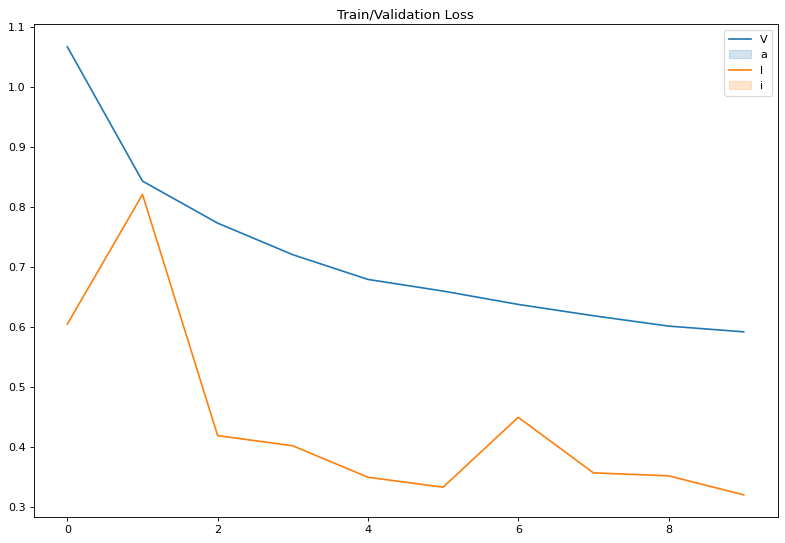

In [42]:

import seaborn as sns
results_plot(tr_loss, ts_loss, 'Train/Validation Loss')

<ipython-input-22-07b15f836379>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-22-07b15f836379>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


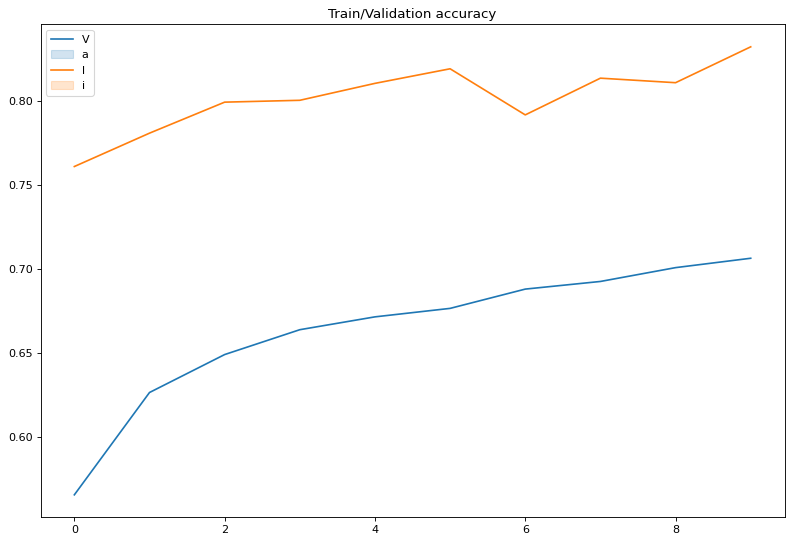

In [43]:
results_plot(tr_acc, ts_acc, 'Train/Validation accuracy')

In [44]:
max(ts_acc)

0.8322683706070287

Точность модели оказалась чуть ниже, чем у модели обученной без аугментации. Причиной этому является слишком маленькое количество эпох, но все конфигурации сравниваются при одинаковом количестве эпох. (Выбрал такое маленькое количество эпох, так как колаб регулярно дает лимит на гпу, из-за чего я уже просрочил дедлайн :( )

Summary сверточной модели

In [45]:
from torchsummary import summary
summary(model, (1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,928
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
            Block-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

Skip connections

так как я уже использовал skip connections в resnet, то в данном пункте просто использую увеличенную архитектуру - resnet34, которая так же использует skip connections

In [46]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet34(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [47]:
layers=[3, 4, 6, 3]
model = ResNet34(BasicBlock, layers, 10).to(device)

In [48]:
from torchsummary import summary
summary(model, (1, 28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

Модель практически в два раза больше предыдущей

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
resnet34_model_aug, *history = train_loop(model, 10, loss_fn, optimizer, trainloader, testloader)

Epoch - 1, train_loss: 1.1283245086669922, val_loss: 0.6172383427619934
Epoch - 2, train_loss: 0.8951984643936157, val_loss: 0.5896608829498291
Epoch - 3, train_loss: 0.8117823600769043, val_loss: 0.6231110692024231
Epoch - 4, train_loss: 0.7558359503746033, val_loss: 0.5430223941802979
Epoch - 5, train_loss: 0.719096839427948, val_loss: 0.40015026926994324
Epoch - 6, train_loss: 0.688144862651825, val_loss: 0.36517396569252014
Epoch - 7, train_loss: 0.6644940972328186, val_loss: 0.35902106761932373
Epoch - 8, train_loss: 0.6457330584526062, val_loss: 0.45122432708740234
Epoch - 9, train_loss: 0.6212417483329773, val_loss: 0.3601265549659729
Epoch - 10, train_loss: 0.6119904518127441, val_loss: 0.37295001745224


На неаугментированных данных

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
resnet34_model_aug, *history = train_loop(model, 10, loss_fn, optimizer, trainloader, testloader)

Epoch - 1, train_loss: 0.28179818391799927, val_loss: 0.2942506968975067
Epoch - 2, train_loss: 0.23297347128391266, val_loss: 0.2677714228630066
Epoch - 3, train_loss: 0.20743988454341888, val_loss: 0.24546299874782562
Epoch - 4, train_loss: 0.20087677240371704, val_loss: 0.23175424337387085
Epoch - 5, train_loss: 0.17583753168582916, val_loss: 0.24549326300621033
Epoch - 6, train_loss: 0.16315831243991852, val_loss: 0.25241443514823914
Epoch - 7, train_loss: 0.15120112895965576, val_loss: 0.2424936294555664
Epoch - 8, train_loss: 0.13687248528003693, val_loss: 0.2531910240650177
Epoch - 9, train_loss: 0.1275007724761963, val_loss: 0.2924173176288605
Epoch - 10, train_loss: 0.11455690115690231, val_loss: 0.2540052831172943


<ipython-input-22-07b15f836379>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-22-07b15f836379>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


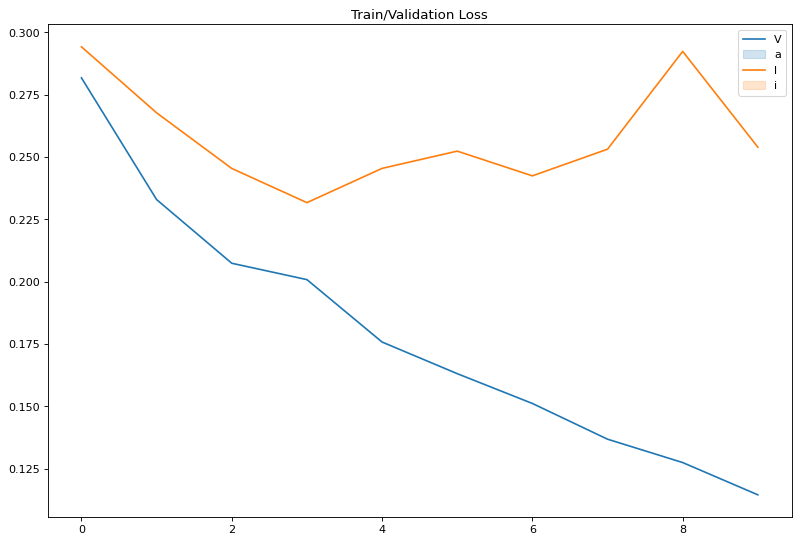

In [52]:
tr_loss, ts_loss, tr_acc, ts_acc = history
tr_loss = [x.to('cpu').detach().numpy().item() for x  in tr_loss]
ts_loss = [x.to('cpu').detach().numpy().item() for x  in ts_loss]
import seaborn as sns
results_plot(tr_loss, ts_loss, 'Train/Validation Loss')

<ipython-input-22-07b15f836379>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(tr_res, palette='red')
<ipython-input-22-07b15f836379>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(val_res, palette='blue')


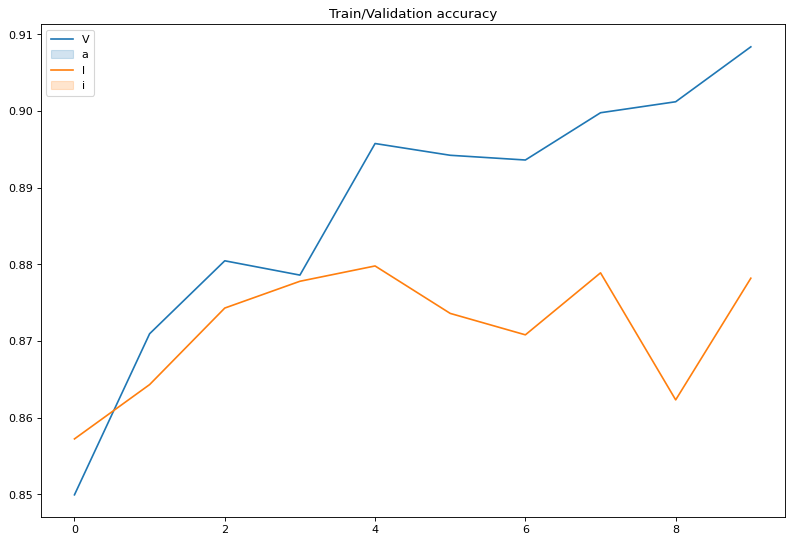

In [53]:
results_plot(tr_acc, ts_acc, 'Train/Validation accuracy')

In [54]:
max(ts_acc)

0.8797923322683706

Результаты модели resnet34, которая использует skip connections оказались лучше, чем результаты предыдущих конфигураций. Причины:
1) Модель имеет больше параметров и слоев свертки
2) Технология skip connection дает больше профита на больших моделях
3) В данной конфигурации не использовалась аугментация, которая при маленьком количестве эпох только затрудняет обучение

Как можно было бы еще улучшить метрики на данном датасете?

1) не просто трансформировать тренировочную выборку, а создавать дополнительные(новые) экземпляры для тренировочной выборке. Тем самым мы не потеряли бы уже имеющиеся данные и расширили их выборку

2) Добавить шедулер для lr, по графикам обучения моделей видно, что ближе к 8-10 эпохе лосс начинает скакать то вниз, то вверх. Виной этому больше lr=0.001, который использовался для быстрого получения лосса < 0.3

3) из второго пункта вытекает, что к добавлению шедулера было бы неплохо увлечить количество эпох. Благодаря шедулеру (например ReduceLROnPlateau) метрики модели не попадали бы в боттлнек так рано